<a href="https://colab.research.google.com/github/cseybold/SmearScore/blob/main/SmearScore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import csv
import os
import pathlib

import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
#upload data here
data_upload = files.upload()
spreadsheet = list(data_upload.keys())[0]

Saving Rd3_all_NumTest=300__ValiaRatio=0.10__Seed=42_TestSelect=balanced slides and scores.csv to Rd3_all_NumTest=300__ValiaRatio=0.10__Seed=42_TestSelect=balanced slides and scores.csv


In [3]:
#upload image here
scan_upload = files.upload()
image_scan = list(scan_upload.keys())[0]

Saving FirstOfTheStitchesBR1141a.png to FirstOfTheStitchesBR1141a.png


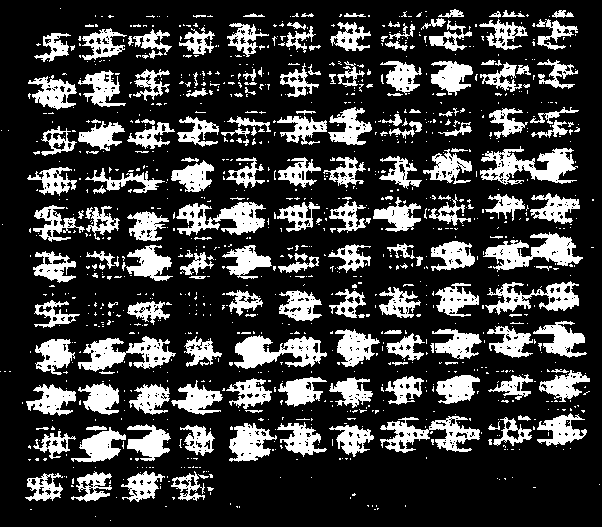

In [4]:
#load image with cv2
image = cv2.imread(image_scan)

#convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#black and white filter
ret, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
cv2_imshow(bin_img)

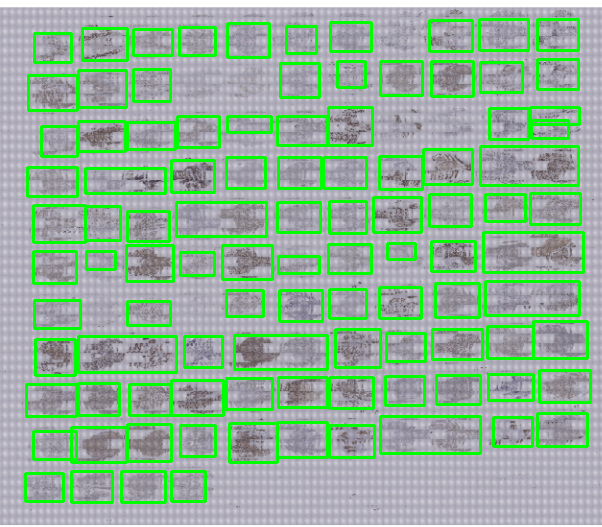

In [5]:
contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_with_rectangles = image.copy()

min_contour_area = 100  # Adjustable threshold

"""
output_directory = "contour_images"
if not os.path.exists(output_directory):
  os.makedirs(output_directory)
"""

box_count = 0
coordinates_list = []

for i, contour in enumerate(contours):
  area = cv2.contourArea(contour)
  if area > min_contour_area:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image_with_rectangles, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Extract and save the contour box as an individual image
    contour_image = image[y:y + h, x:x + w]
    #cv2.imwrite(os.path.join(output_directory, f"contour_{box_count}.png"), contour_image)

    box_count += 1
    coordinates_list.append((x, y, w, h))


cv2_imshow(image_with_rectangles)

Enter #rows: 11
Enter #columns: 11
Enter slide id: BR1141a


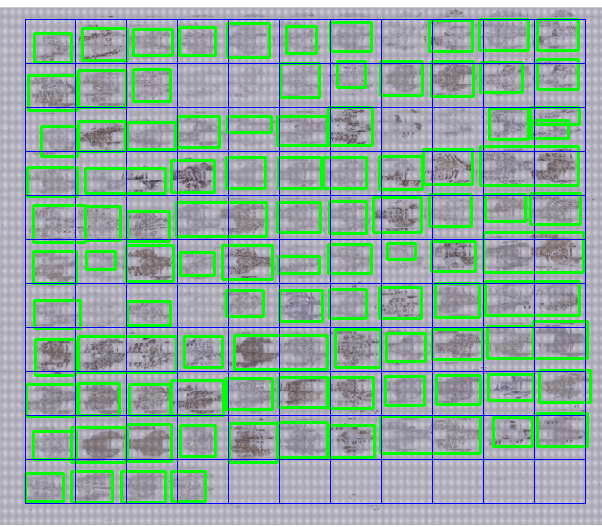

In [29]:
# Dimension of grid (automate this / get from website?)
grid_rows = int(input("Enter #rows: "))
grid_columns = int(input("Enter #columns: "))
slide_id = input("Enter slide id: ")

# Calculate mean of box width and height
mean_w = np.mean([coord[2] for coord in coordinates_list])
mean_h = np.mean([coord[3] for coord in coordinates_list])

# Set initial boundaries
x_min = image.shape[1]
y_min = image.shape[0]
x_max = 0
y_max = 0

# Iterate through contours to find boundaries
for coord in coordinates_list:
  x, y, _, _ = coord

  if x < x_min:
    x_min = x

  if y < y_min:
    y_min = y

  if x + mean_w > x_max:
    x_max = x + mean_w

  if y + mean_h > y_max:
    y_max = y + mean_h

x_step = (x_max - x_min) / grid_columns
y_step = (y_max - y_min) / grid_rows

output_directory = "grid_images"  # Directory to save the contour images

if not os.path.exists(output_directory):
  os.makedirs(output_directory)

# Open the CSV file
with open(spreadsheet, "r") as f:
  reader = csv.reader(f)
  for i in range(grid_rows):
    for j in range(grid_columns):
      x_start = int(x_min + j * x_step)
      y_start = int(y_min + i * y_step)
      x_end = int(x_min + (j + 1) * x_step)
      y_end = int(y_min + (i + 1) * y_step)

      cv2.rectangle(image_with_rectangles, (x_start, y_start), (x_end, y_end), (255, 0, 0), 1)

      core_id = f"{chr(65+i)}{j+1}"
      row_found = False
      f.seek(0)
      for row in reader:
        if row[1] == slide_id and row[2] == core_id:
          score = row[7]
          row_found = True
          break
      if not row_found:
        score = "X"

      grid_image = image[y_start:y_end, x_start:x_end]
      cv2.imwrite(os.path.join(output_directory, f"{slide_id}_{core_id}_{score}.png"), grid_image)

cv2_imshow(image_with_rectangles)

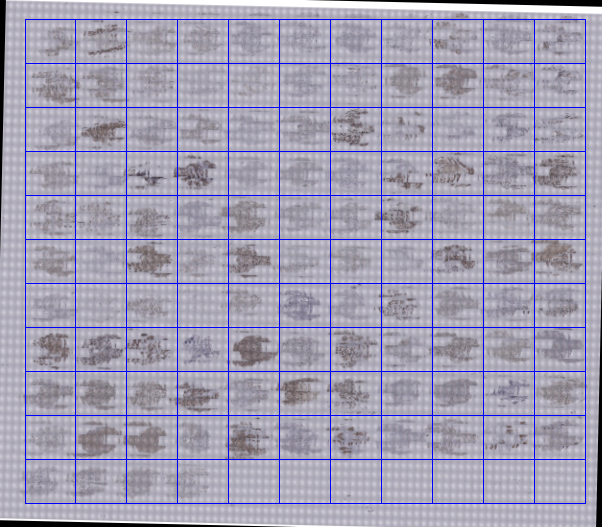

In [30]:
#image rotation
angle = -1.3

# Define the center of rotation
center = (image.shape[1] // 2, image.shape[0] // 2)

# Generate the rotation matrix
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

# Apply the rotation to the original image
rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

# Draw rectangles on the rotated image
for i in range(grid_rows):
    for j in range(grid_columns):
        x_start = int(x_min + j * x_step)
        y_start = int(y_min + i * y_step)
        x_end = int(x_min + (j + 1) * x_step)
        y_end = int(y_min + (i + 1) * y_step)

        cv2.rectangle(rotated_image, (x_start, y_start), (x_end, y_end), (255, 0, 0), 1)

# Write the rotated image to the output directory
#cv2.imwrite(os.path.join(output_directory, f"{slide_id}_rotated.png"), rotated_image)

# Display the rotated image with the grid
cv2_imshow(rotated_image)

In [ ]:
file_paths = tf.io.gfile.glob("/content/grid_images/*.png")

gridimgs = tf.data.Dataset.from_tensor_slices(file_paths).map(tf.io.read_file)
gridimgs = gridimgs.map(tf.image.decode_image)


In [ ]:
batch_size = 32
img_height = y_step
img_width = x_step

train_ds = tf.keras.utils.image_dataset_from_directory(
  gridimgs,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(y_step, x_step),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  gridimgs,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(y_step, x_step),
  batch_size=batch_size)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

TypeError: ignored